# 1. Import Library

In [51]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from io import StringIO
import pickle
import random
import re
import string
import csv
import requests
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Add, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

In [52]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 2. Load Dataset

In [53]:
df = pd.read_csv("data/ulasan.csv")

In [54]:
df.head(3).T

,0,1,2
reviewId,3c274eb3-4de3-41fd-85be-85fb22a55c8b,9ace9065-c0c1-40f6-89c4-11dfaedb9926,3b8feda9-cfe9-43fb-b6e4-00c5f60d1fa9
replyContent,NaN,"Hi Kak, maaf udah bikin kamu ga tenang. DANA aman karena memiliki fitur keamanan seperti DANA VIZ dan Passkey ya. Terkait transaksi yg tdk dikenal, yuk hub DIANA pd menu ""Aktivitas"" ya. Jgn pernah memberi kode OTP/PIN kpd orang yg tidak dikenal dan mohon pastikan kembali untuk check account yg terhubung pd apk DANA kamu ya. Thx -NA-","Hi Kak, maaf udah bikin kamu ga tenang. Terkait keluhan saldo yg belum diterima agar kami bantu lebih lanjut, Kakak dapat menghubungi DIANA pd menu ""Me/Saya"" ya Kak. Kami pasti akan bantu keluhan kamu sebaik mungkin. Thanks -NA-"
thumbsUpCount,38,516,854
repliedAt,NaN,2025-03-30 23:43:12,2025-03-12 01:25:35
reviewCreatedVersion,2.77.0,2.76.0,2.77.0
userImage,https://play-lh.googleusercontent.com/a-/ALV-UjXAoiHDP7Isen3VEMKRXlDd4eIkTWb5OTA0TRgGjXjOfQezjiZS,https://play-lh.googleusercontent.com/a/ACg8ocIdTjQthyE-G245dJp9A9kyqWm-_O8wfRTBiyuP3-haYZEmkQ=mo,https://play-lh.googleusercontent.com/a-/ALV-UjUlx1A5Nz05LYLtHbYWBzO-nE1rJY__HG1oUwSJj33o2UhVyxA
appVersion,2.77.0,2.76.0,2.77.0
userName,Ano Kustiawan,Rita Clark,Irawan mas IR
at,2025-03-29 23:56:30,2025-03-23 21:20:12,2025-03-28 01:49:41
score,2,1,1


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              20000 non-null  object
 1   replyContent          12187 non-null  object
 2   thumbsUpCount         20000 non-null  int64 
 3   repliedAt             12187 non-null  object
 4   reviewCreatedVersion  17640 non-null  object
 5   userImage             20000 non-null  object
 6   appVersion            17640 non-null  object
 7   userName              20000 non-null  object
 8   at                    20000 non-null  object
 9   score                 20000 non-null  int64 
 10  content               20000 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.7+ MB


# 3. Data Preprocessing

## Check and fix Missing values and duplicate

In [56]:
df.isnull().sum()

reviewId                   0
replyContent            7813
thumbsUpCount              0
repliedAt               7813
reviewCreatedVersion    2360
userImage                  0
appVersion              2360
userName                   0
at                         0
score                      0
content                    0
dtype: int64

In [57]:
print(f"jumlah missing values: {df.isnull().sum().sum()}")

jumlah missing values: 20346


In [58]:
df.loc[:, 'appVersion'] = df['appVersion'].fillna(df['appVersion'].mode()[0])
df.loc[:, 'reviewCreatedVersion'] = df['reviewCreatedVersion'].fillna(df['reviewCreatedVersion'].mode()[0])
df.loc[:, 'replyContent'] = df['replyContent'].fillna(df['replyContent'].mode()[0])
df.loc[:, 'repliedAt'] = df['repliedAt'].fillna(df['repliedAt'].mode()[0])

In [59]:
df.isnull().sum()

reviewId                0
replyContent            0
thumbsUpCount           0
repliedAt               0
reviewCreatedVersion    0
userImage               0
appVersion              0
userName                0
at                      0
score                   0
content                 0
dtype: int64

In [60]:
print(f"jumlah missing values: {df.isnull().sum().sum()}")

jumlah missing values: 0


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              20000 non-null  object
 1   replyContent          20000 non-null  object
 2   thumbsUpCount         20000 non-null  int64 
 3   repliedAt             20000 non-null  object
 4   reviewCreatedVersion  20000 non-null  object
 5   userImage             20000 non-null  object
 6   appVersion            20000 non-null  object
 7   userName              20000 non-null  object
 8   at                    20000 non-null  object
 9   score                 20000 non-null  int64 
 10  content               20000 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.7+ MB


In [62]:
print(f"Jumlah duplikat: {df.duplicated().sum()}")

Jumlah duplikat: 0


## Content Cleaning

In [63]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # Remove hashtags
    text = re.sub(r'RT[\s]', '', text) # Remove RT
    text = re.sub(r"http\S+", '', text) # Remove links
    text = re.sub(r'[0-9]+', '', text) # Remove numbers
    text = re.sub(r'\.+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text) # Remove special characters
    

    text = text.replace('\n', ' ') # Replace new line into space
    text = text.strip() # Trim spaces from both sides
    return text

def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower()
    return text

def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text

def filteringText(text): # Remove stopwors in a text
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update([
    'iya', 'yaa', 'gak', 'nya', 'na', 'sih', 'ku', 'di', 'ga', 'ya', 'gaa', 'loh',
    'kah', 'woi', 'woii', 'woy', 'dong', 'nih', 'oke', 'eh', 'oh', 'sama', 'buat',
    'aku', 'kamu', 'anda', 'lagi', 'juga', 'tak', 'boleh', 'udah', 'tuh', 'lah', 'kan',
    'coba', 'kayak', 'saya', 'sekali', 'gitu', 'terus', 'bakal', 'aja', 'emang',
    'banget', 'tentu', 'biar', 'jadi', 'begitu', 'baru', 'apaan', 'deh', 'toh',
    'ntar', 'tapi', 'malah', 'tetep', 'gimana', 'padahal', 'nanti', 'pasti', 'bukan',
    'ke', 'kok', 'udah', 'mah', 'capek', 'tau', 'sih', 'dong', 'loh', 'nih', 'yah',
    'aduh', 'wkwk', 'hehe', 'hmm', 'huhu', 'hadeh', 'yuk', 'ayo', 'wkwkwk', 'haha',
    'hiks', 'cie', 'weleh', 'welehweleh', 'alah', 'buset', 'mantap', 'mantul',
    'oke', 'sip', 'anjir', 'anjay', 'astaga', 'wow', 'ehm', 'waw', 'weleh',
    'bang', 'bro', 'sis', 'gan', 'om', 'tante', 'pak', 'bu', 'mas', 'mbak', 'dek',
    'guys', 'bruh', 'sob', 'beneran', 'serius', 'parah', 'auto', 'gimana',
    'nih', 'dong', 'lah', 'kan', 'sampe', 'ampe', 'sama', 'aja', 'soalnya',
    'sebenernya', 'sebenarnya', 'mending', 'terlalu', 'cukup', 'lumayan',
    'kek', 'mirip', 'macam', 'kayaknya', 'kali', 'mau', 'neng', 'yaa', 'dong',
    'please', 'deket', 'jauh', 'pokoknya', 'seharusnya', 'sebaiknya', 'sepertinya',
    'pastinya', 'mungkin', 'entah', 'so', 'then', 'anyway', 'btw', 'btw.', 'btw,',
    'nah', 'loh', 'hayo', 'makanya', 'jadinya', 'abis', 'gimana', 'soalnya', 'oke'
])

    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

    return stemmed_text
def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

In [64]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal",
              "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong",
              "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha",
              "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak",
              "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa",
              "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik",
              "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu",
              "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget",
              "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung",
              "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan",
              "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana",
              "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan",
              "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar",
              "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng",
              "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong",
              "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak",
              "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi",
              "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa",
              "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri",
              "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci",
              "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok",
              "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor",
              "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik",
              "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan",
              "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu",
              "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana",
              "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi",
              "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak",
              "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back",
              "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa",
              "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa",
              "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi",
              "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana",
              "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya",
              "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya",
              "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he",
              "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus",
              "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka",
              "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja",
              "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga",
              "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara",
              "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi",
              "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu",
              "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya",
              "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala",
              "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah",
              "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan",
              "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau",
              "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya",
              "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat",
              "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor",
              "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran",
              "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat",
              "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan",
              "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa",
              "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan",
              "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta",
              "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu",
              "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu",
              "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin",
              "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman",
              "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak",
              "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa",
              "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ",
              "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini",
              "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku",
              "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan",
              "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah",
              "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri",
              "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini",
              "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti",
              "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil",
              "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic",
              "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar",
              "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri",
              "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah",
              "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah",
              "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah",
              "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", 
              "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti",
              "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor",
              "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika",
              "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus",
              "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa",
              "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara",
              "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok",
              "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih",
              "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian",
              "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat",
              "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi",
              "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah",
              "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi",
              "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan",
              "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", 
              "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", 
              "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", 
              "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", 
              "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah",
              "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", 
              "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", 
              "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", 
              "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", 
              "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", 
              "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", 
              "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", 
              "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", 
              "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", 
              "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas",
              "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan",
              "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum",
              "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis",
              "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau",
              "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung",
              "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh",
              "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki",
              "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa",
              "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep",
              "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang",
              "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek",
              "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur",
              "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu",
              "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya",
              "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak",
              "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah",
              "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat",
              "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi",
              "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", 
              "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik",
              "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak",
              "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak",
              "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan",
              "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur",
              "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih",
              "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan",
              "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak",
              "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus",
              "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok",
              "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena",
              "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya",
              "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan",
              "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat",
              "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum",
              "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat",
              "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main",
              "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan",
              "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin",
              "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta",
              "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing",
              "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa",
              "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", 
              "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", 
              "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", 
              "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", 
              "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", 
              "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", 
              "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", 
              "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram",
              "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", 
              "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", 
              "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", 
              "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti",
              "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa",
              "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap",
              "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", 
              "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV",
              "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah",
              "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung",
              "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend",
              "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik",
              "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya",
              "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu",
              "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman",
              "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling",
              "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut",
              "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu",
              "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang",
              "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap",
              "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend",
              "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin", 
              "bagu": "bagus", "x": "kali"}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [65]:
df.head(3).T

,0,1,2
reviewId,3c274eb3-4de3-41fd-85be-85fb22a55c8b,9ace9065-c0c1-40f6-89c4-11dfaedb9926,3b8feda9-cfe9-43fb-b6e4-00c5f60d1fa9
replyContent,"Live Chat siap bantu Keluhan transaksi Kamu: Buka App DANA, Pilih History/Riwayat, Pilih transaksi yg mau dilaporin, Pilih CHAT\n\nKeluhan Akun Premium: Buka aplikasi DANA, Pilih Me/Saya, Klik ket Alasan Gagal/Reason Failed, Klik menu CHAT\n\nKeluhan lainnya email ke help@dana.id","Hi Kak, maaf udah bikin kamu ga tenang. DANA aman karena memiliki fitur keamanan seperti DANA VIZ dan Passkey ya. Terkait transaksi yg tdk dikenal, yuk hub DIANA pd menu ""Aktivitas"" ya. Jgn pernah memberi kode OTP/PIN kpd orang yg tidak dikenal dan mohon pastikan kembali untuk check account yg terhubung pd apk DANA kamu ya. Thx -NA-","Hi Kak, maaf udah bikin kamu ga tenang. Terkait keluhan saldo yg belum diterima agar kami bantu lebih lanjut, Kakak dapat menghubungi DIANA pd menu ""Me/Saya"" ya Kak. Kami pasti akan bantu keluhan kamu sebaik mungkin. Thanks -NA-"
thumbsUpCount,38,516,854
repliedAt,2023-08-11 18:46:23,2025-03-30 23:43:12,2025-03-12 01:25:35
reviewCreatedVersion,2.77.0,2.76.0,2.77.0
userImage,https://play-lh.googleusercontent.com/a-/ALV-UjXAoiHDP7Isen3VEMKRXlDd4eIkTWb5OTA0TRgGjXjOfQezjiZS,https://play-lh.googleusercontent.com/a/ACg8ocIdTjQthyE-G245dJp9A9kyqWm-_O8wfRTBiyuP3-haYZEmkQ=mo,https://play-lh.googleusercontent.com/a-/ALV-UjUlx1A5Nz05LYLtHbYWBzO-nE1rJY__HG1oUwSJj33o2UhVyxA
appVersion,2.77.0,2.76.0,2.77.0
userName,Ano Kustiawan,Rita Clark,Irawan mas IR
at,2025-03-29 23:56:30,2025-03-23 21:20:12,2025-03-28 01:49:41
score,2,1,1


In [66]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
df['text_clean'] = df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
df['text_akhir'] = df['text_stopword'].apply(toSentence)

In [67]:
df.head(3).T

,0,1,2
reviewId,3c274eb3-4de3-41fd-85be-85fb22a55c8b,9ace9065-c0c1-40f6-89c4-11dfaedb9926,3b8feda9-cfe9-43fb-b6e4-00c5f60d1fa9
replyContent,"Live Chat siap bantu Keluhan transaksi Kamu: Buka App DANA, Pilih History/Riwayat, Pilih transaksi yg mau dilaporin, Pilih CHAT\n\nKeluhan Akun Premium: Buka aplikasi DANA, Pilih Me/Saya, Klik ket Alasan Gagal/Reason Failed, Klik menu CHAT\n\nKeluhan lainnya email ke help@dana.id","Hi Kak, maaf udah bikin kamu ga tenang. DANA aman karena memiliki fitur keamanan seperti DANA VIZ dan Passkey ya. Terkait transaksi yg tdk dikenal, yuk hub DIANA pd menu ""Aktivitas"" ya. Jgn pernah memberi kode OTP/PIN kpd orang yg tidak dikenal dan mohon pastikan kembali untuk check account yg terhubung pd apk DANA kamu ya. Thx -NA-","Hi Kak, maaf udah bikin kamu ga tenang. Terkait keluhan saldo yg belum diterima agar kami bantu lebih lanjut, Kakak dapat menghubungi DIANA pd menu ""Me/Saya"" ya Kak. Kami pasti akan bantu keluhan kamu sebaik mungkin. Thanks -NA-"
thumbsUpCount,38,516,854
repliedAt,2023-08-11 18:46:23,2025-03-30 23:43:12,2025-03-12 01:25:35
reviewCreatedVersion,2.77.0,2.76.0,2.77.0
userImage,https://play-lh.googleusercontent.com/a-/ALV-UjXAoiHDP7Isen3VEMKRXlDd4eIkTWb5OTA0TRgGjXjOfQezjiZS,https://play-lh.googleusercontent.com/a/ACg8ocIdTjQthyE-G245dJp9A9kyqWm-_O8wfRTBiyuP3-haYZEmkQ=mo,https://play-lh.googleusercontent.com/a-/ALV-UjUlx1A5Nz05LYLtHbYWBzO-nE1rJY__HG1oUwSJj33o2UhVyxA
appVersion,2.77.0,2.76.0,2.77.0
userName,Ano Kustiawan,Rita Clark,Irawan mas IR
at,2025-03-29 23:56:30,2025-03-23 21:20:12,2025-03-28 01:49:41
score,2,1,1


# 4. Data Labelling

In [68]:
def fetch_lexicon(url: str) -> dict:
    response = requests.get(url)
    lexicon = {}
    if response.status_code == 200:
        reader = csv.reader(StringIO(response.text))
        for row in reader:
            lexicon[row[0]] = int(row[1])
    else:
        print(f"Failed to fetch lexicon data from {url}")
    return lexicon

lexicon_positive = fetch_lexicon('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
lexicon_negative = fetch_lexicon('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

In [99]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        score += lexicon_positive.get(word, 0) + lexicon_negative.get(word, 0)
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'
        
    return score, polarity

In [100]:
df[['polarity_score', 'polarity']] = pd.DataFrame(
    df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia).tolist(),
    index=df.index
)
print(df['polarity'].value_counts())

polarity
positive    11060
negative     7851
neutral      1089
Name: count, dtype: int64


In [135]:
from sklearn.utils import resample

# Pisahkan data berdasarkan kelas
df_positive = df[df['polarity'] == 'positive']
df_negative = df[df['polarity'] == 'negative']
df_neutral  = df[df['polarity'] == 'neutral']

# Tentukan jumlah sampel target, misalnya samakan dengan kelas mayoritas (positive)
target_count = df_positive.shape[0]

# Oversample kelas negative
df_negative_upsampled = resample(
    df_negative,
    replace=True,
    n_samples=target_count,
    random_state=42
)

# Oversample kelas neutral
df_neutral_upsampled = resample(
    df_neutral,
    replace=True,
    n_samples=target_count,
    random_state=42
)

# Gabungkan kembali data oversampling dengan kelas positive (yang tidak diubah)
df_balanced = pd.concat([df_positive, df_negative_upsampled, df_neutral_upsampled])

# Acak data jika perlu
df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Cek distribusi kelas
print(df['polarity'].value_counts())

polarity
neutral     11060
positive    11060
negative    11060
Name: count, dtype: int64


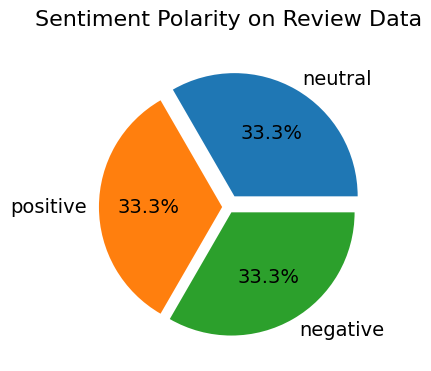

In [115]:
fig, ax = plt.subplots(figsize=(4, 4))
sizes = [count for count in df['polarity'].value_counts()]
labels = list(df['polarity'].value_counts().index)
explode = (0.1, 0.05, 0.05)
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})
ax.set_title('Sentiment Polarity on Review Data', fontsize=16, pad=20)
plt.show()

In [116]:
def process_reviews(df, polarity, sort_ascending=None, top_n=None):
    """
    Filter, sort, and visualize word cloud for reviews based on polarity.
    """
    pd.set_option('display.max_colwidth', 3000)
    
    # Filter reviews by polarity
    reviews = df.loc[df['polarity'] == polarity, ['text_akhir', 'polarity_score', 'polarity', 'text_stopword']]
    
    # Sort if needed
    if sort_ascending is not None:
        reviews = reviews.sort_values('polarity_score', ascending=sort_ascending)
    
    # Take top N rows if specified
    if top_n:
        reviews = reviews.head(top_n)
    
    reviews = reviews.reset_index(drop=True)
    reviews.index += 1
    
    # Generate word cloud
    list_words = " ".join(word for review in reviews['text_stopword'] for word in review)
    wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)
    
    # Plot word cloud
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(f'Word Cloud of {polarity.capitalize()} Review Data', fontsize=18)
    ax.imshow(wordcloud)
    ax.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    
    return reviews

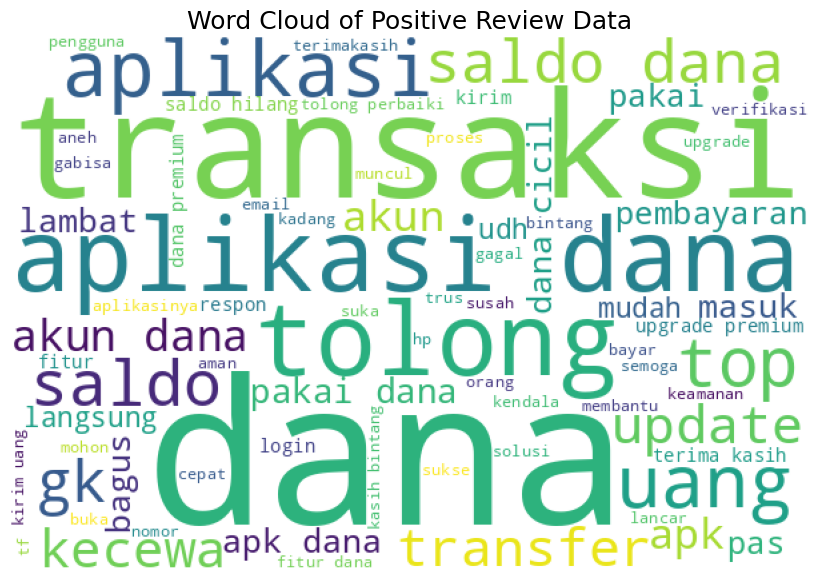

In [117]:
positive_review = process_reviews(df, 'positive')

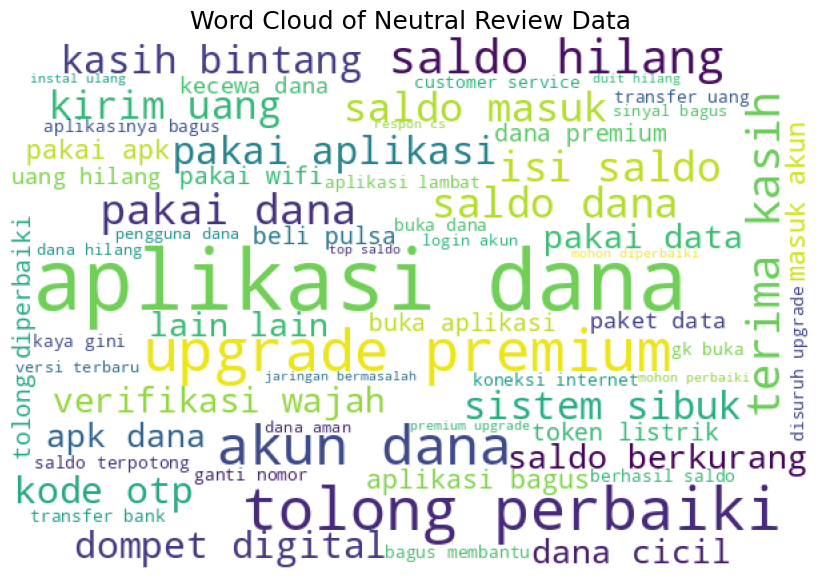

In [118]:
neutral_review = process_reviews(df, 'neutral', sort_ascending=False)

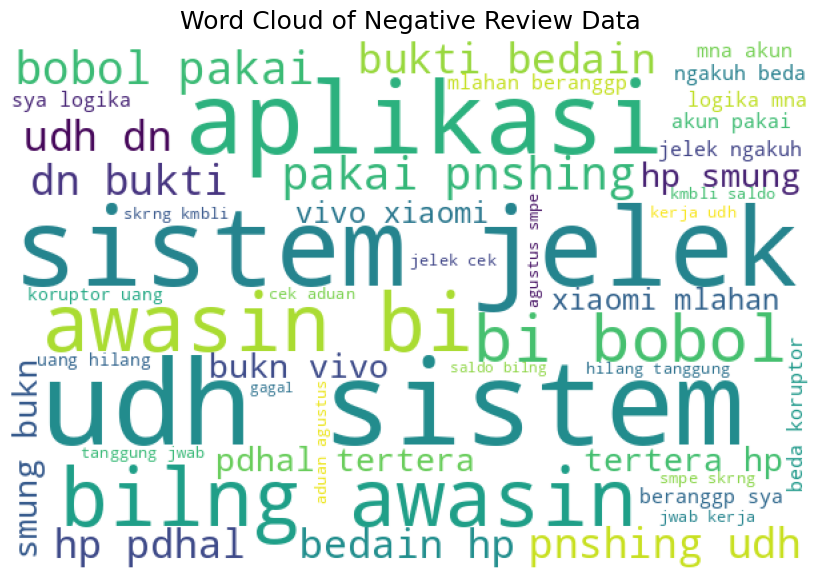

In [119]:
negative_review = process_reviews(df, 'negative', sort_ascending=True, top_n=10)

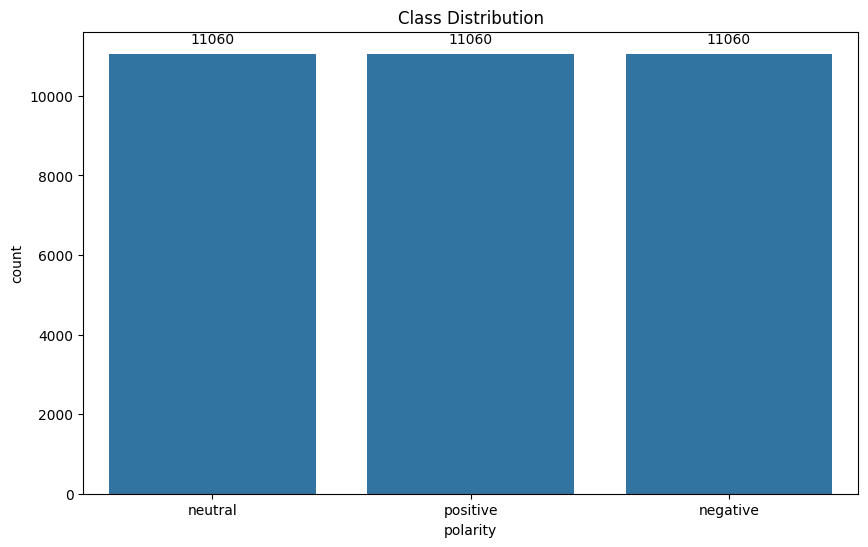

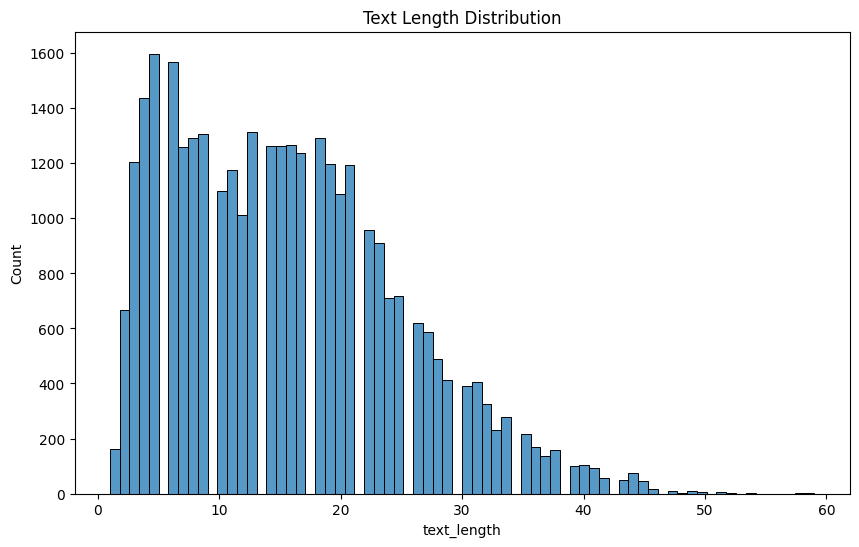

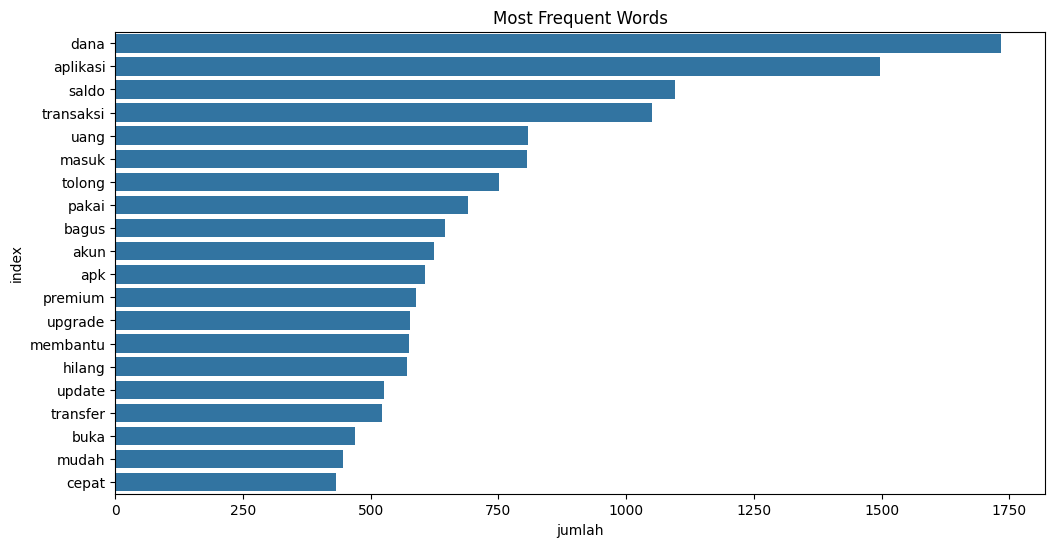

In [120]:
# Class Distribution Plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x='polarity', data=df, ax=ax)
ax.set_title('Class Distribution')
for patch in ax.patches:
    ax.annotate(f'{patch.get_height():.0f}',
                (patch.get_x() + patch.get_width() / 2, patch.get_height()),
                ha='center', va='center',
                xytext=(0, 10), textcoords='offset points')
plt.show()

# Text Length Distribution Plot
df['text_length'] = df['text_akhir'].str.split().str.len()
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df['text_length'], ax=ax)
ax.set_title('Text Length Distribution')
plt.show()

# TF-IDF and Most Frequent Words Plot
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = (
    tfidf_df.sum()
    .reset_index(name='jumlah')
    .sort_values('jumlah', ascending=False)
    .head(20)
)
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='jumlah', y='index', data=tfidf_df, ax=ax)
ax.set_title('Most Frequent Words')
plt.show()


# 5. Data Splitting

In [121]:
df.head(3).T

,0,1,2
reviewId,f534c5e2-2458-4988-aaa1-58557c67a27e,2ae15029-3b35-458d-b574-cd26d7d5ebbc,1f1fe6bd-434b-429a-8eed-14fbbf07e192
replyContent,"Live Chat siap bantu Keluhan transaksi Kamu: Buka App DANA, Pilih History/Riwayat, Pilih transaksi yg mau dilaporin, Pilih CHAT\n\nKeluhan Akun Premium: Buka aplikasi DANA, Pilih Me/Saya, Klik ket Alasan Gagal/Reason Failed, Klik menu CHAT\n\nKeluhan lainnya email ke help@dana.id","Live Chat siap bantu Keluhan transaksi Kamu: Buka App DANA, Pilih History/Riwayat, Pilih transaksi yg mau dilaporin, Pilih CHAT\n\nKeluhan Akun Premium: Buka aplikasi DANA, Pilih Me/Saya, Klik ket Alasan Gagal/Reason Failed, Klik menu CHAT\n\nKeluhan lainnya email ke help@dana.id","Live Chat siap bantu Keluhan transaksi Kamu: Buka App DANA, Pilih History/Riwayat, Pilih transaksi yg mau dilaporin, Pilih CHAT\n\nKeluhan Akun Premium: Buka aplikasi DANA, Pilih Me/Saya, Klik ket Alasan Gagal/Reason Failed, Klik menu CHAT\n\nKeluhan lainnya email ke help@dana.id"
thumbsUpCount,0,0,0
repliedAt,2023-08-11 18:46:23,2023-08-11 18:46:23,2023-08-11 18:46:23
reviewCreatedVersion,2.72.0,2.72.0,2.77.0
userImage,https://play-lh.googleusercontent.com/a-/ALV-UjXPrUMFXQ4ovEEtmoe-dFdylg9XSBO6WoDg1OVWtI6h9t0D7a0,https://play-lh.googleusercontent.com/a-/ALV-UjVa9PTg8evSG0fR6DYyoUsrhoORw4T3IsSFOfRr_ylSFqr64Bs_,https://play-lh.googleusercontent.com/a-/ALV-UjXCSHJI6QVmvFcRP3zNgidbLJ4e0-V-Q63XR10MF38h5Y9XlXCE
appVersion,2.72.0,2.72.0,2.77.0
userName,Hery Chapry,Murdiana Diana,Septi Yanto
at,2025-01-16 23:54:54,2025-01-21 18:21:01,2025-03-27 18:24:31
score,4,5,1


In [122]:
# Split data mentah (sebelum ekstraksi fitur)
X = df['text_akhir']
y = df['polarity']

# Encode label dengan satu LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

# One-hot encoding untuk label
y_train_ohe = to_categorical(y_train_encoded)
y_val_ohe = to_categorical(y_val_encoded)
y_test_ohe = to_categorical(y_test_encoded)

# Simpan LabelEncoder
with open("label_encoder.pkl", "wb") as le_file:
    pickle.dump(le, le_file)

In [123]:
def preprocess_data(X_train_raw, X_val_raw, X_test_raw, method='tfidf'):
    """
    Preprocessing data dengan ekstraksi fitur.

    Parameter:
    - X_train_raw: Data teks latih (belum diolah).
    - X_val_raw: Data teks validasi (belum diolah).
    - X_test_raw: Data teks uji (belum diolah).
    - method: Metode ekstraksi fitur ('tfidf' atau 'count').

    Mengembalikan:
    - X_train: Data fitur latih (sparse matrix).
    - X_val: Data fitur validasi (sparse matrix).
    - X_test: Data fitur uji (sparse matrix).
    - vectorizer: Objek vectorizer yang telah di-fit.
    """
    if method == 'tfidf':
        vectorizer = TfidfVectorizer(max_features=500, min_df=15, max_df=0.9)
        vectorizer_filename = "vectorizer_tfidf.pkl"
        print("vectorizer_tfidf.pkl berhasil disimpan")
    elif method == 'count':
        vectorizer = CountVectorizer(max_features=1000, min_df=10, max_df=0.8)
        vectorizer_filename = "vectorizer_count.pkl"
        print("vectorizer_count.pkl berhasil disimpan")
    else:
        raise ValueError("Method harus 'tfidf' atau 'count'.")

    # Ekstraksi fitur
    X_train = vectorizer.fit_transform(X_train_raw)
    X_val = vectorizer.transform(X_val_raw)
    X_test = vectorizer.transform(X_test_raw)

    # Simpan vectorizer
    with open(vectorizer_filename, "wb") as vec_file:
        pickle.dump(vectorizer, vec_file)

    return X_train, X_val, X_test, vectorizer

In [124]:
# Pertama, pisahkan data menjadi train+validation (80%) dan test (20%)
X_trainval_raw, X_test_raw, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Kemudian, pisahkan data train+validation menjadi training (60% data awal) dan validation (20% data awal)
# Note: 0.25 * 80% = 20% sehingga distribusinya menjadi 60:20:20
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_trainval_raw, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)

In [125]:
# === Ekstraksi TF-IDF ===
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vectorizer = preprocess_data(
    X_train_raw, X_val_raw, X_test_raw, method='tfidf'
)

# === Ekstraksi CountVectorizer ===
X_train_count, X_val_count, X_test_count, count_vectorizer = preprocess_data(
    X_train_raw, X_val_raw, X_test_raw, method='count'
)

vectorizer_tfidf.pkl berhasil disimpan
vectorizer_count.pkl berhasil disimpan


# 6. Pemodelan

## Percobaan 1

In [126]:
# Definisikan arsitektur model dengan penyesuaian pada dropout dan penambahan BatchNormalization tambahan
model = Sequential([
    Input(shape=(X_train_tfidf.shape[1],)),
    Dense(1024, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(512, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(3, activation='softmax')
])

# Kompilasi model dengan optimizer Adam dan learning rate awal 0.001
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callback untuk menghentikan training secara dini jika metrik validasi tidak membaik
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Callback untuk menyimpan model terbaik berdasarkan validasi
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Callback untuk mengurangi learning rate jika validasi tidak meningkat
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, min_lr=1e-6)

# Training model dengan peningkatan jumlah epoch (dengan early stopping)
history = model.fit(
    X_train_tfidf.toarray(), y_train_ohe,
    validation_data=(X_val_tfidf.toarray(), y_val_ohe),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

# Evaluasi model pada test set
test_loss, test_accuracy = model.evaluate(X_test_tfidf.toarray(), y_test_ohe, verbose=1)

print(f'Akurasi pada test set: {test_accuracy}')

Epoch 1/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6157 - loss: 0.9544
Epoch 1: val_accuracy improved from -inf to 0.68008, saving model to best_model.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.6160 - loss: 0.9536 - val_accuracy: 0.6801 - val_loss: 0.7358 - learning_rate: 0.0010
Epoch 2/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8879 - loss: 0.3180
Epoch 2: val_accuracy improved from 0.68008 to 0.93565, saving model to best_model.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8879 - loss: 0.3179 - val_accuracy: 0.9357 - val_loss: 0.2276 - learning_rate: 0.0010
Epoch 3/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9347 - loss: 0.1832
Epoch 3: val_accuracy improved from 0.93565 to 0.93686, saving model to best_model.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9347 - loss: 0.1832 - val_accuracy: 0.9369 - val_loss: 0.2096 - learning_rate: 0.0010
Epoch 4/30
309/312 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/

## Percobaan 2

In [127]:
# Definisikan arsitektur model dengan penyesuaian pada dropout dan penambahan BatchNormalization tambahan
model2 = Sequential([
    Input(shape=(X_train_count.shape[1],)),
    Dense(1024, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.3), # Nilai dropout diturunkan dari 0.6 ke 0.5
    Dense(512, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.2), # Nilai dropout diturunkan dari 0.5 ke 0.4
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(), # Menambahkan normalisasi agar distribusi data lebih stabil
    Dropout(0.1), # Tambahan dropout untuk layer ini guna mengurangi overfitting
    Dense(3, activation='softmax')
])

# Kompilasi model dengan optimizer Adam dan learning rate awal 0.001
model2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callback untuk menghentikan training secara dini jika metrik validasi tidak membaik
early_stop2 = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Callback untuk menyimpan model terbaik berdasarkan validasi
checkpoint2 = ModelCheckpoint('best_model2.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Callback untuk mengurangi learning rate jika validasi tidak meningkat
reduce_lr2 = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, min_lr=1e-6)

# Training model dengan peningkatan jumlah epoch (dengan early stopping)
history2 = model2.fit(
    X_train_count.toarray(), y_train_ohe,
    validation_data=(X_val_count.toarray(), y_val_ohe),
    epochs=30, # Epoch ditingkatkan agar model memiliki kesempatan belajar lebih lama
    batch_size=64,
    callbacks=[early_stop2, checkpoint2, reduce_lr2]
)

# Evaluasi model pada test set
test_loss, test_accuracy = model2.evaluate(X_test_count.toarray(), y_test_ohe, verbose=1)

print(f'Akurasi pada test set: {test_accuracy}')

Epoch 1/30
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6577 - loss: 0.8765
Epoch 1: val_accuracy improved from -inf to 0.86272, saving model to best_model2.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6583 - loss: 0.8749 - val_accuracy: 0.8627 - val_loss: 0.4048 - learning_rate: 0.0010
Epoch 2/30
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9153 - loss: 0.2342
Epoch 2: val_accuracy improved from 0.86272 to 0.94002, saving model to best_model2.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9154 - loss: 0.2340 - val_accuracy: 0.9400 - val_loss: 0.1895 - learning_rate: 0.0010
Epoch 3/30
310/312 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9632 - loss: 0.1084
Epoch 3: val_accuracy improved from 0.94002 to 0.94711, saving model to best_model2.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9632 - loss: 0.1083 - val_accuracy: 0.9471 - val_loss: 0.1970 - learning_rate: 0.0010
Epoch 4/30
310/312 ━━━━━━━━━━━━━━━━━━━━ 0s 21

## Percobaan 3

In [128]:
# Input layer
input_layer = Input(shape=(X_train_tfidf.shape[1],))

# Layer pertama
dense1 = Dense(512, kernel_initializer='he_normal')(input_layer)
bn1 = BatchNormalization()(dense1)
act1 = Activation('relu')(bn1)

# Residual block
dense2 = Dense(512, kernel_initializer='he_normal')(act1)
bn2 = BatchNormalization()(dense2)
act2 = Activation('relu')(bn2)
drop1 = Dropout(0.4)(act2)

# Skip connection: menambahkan output layer pertama (act1) ke output dari residual block
residual = Add()([act1, drop1])
act3 = Activation('relu')(residual)

# Layer tambahan
dense3 = Dense(256, kernel_initializer='he_normal')(act3)
bn3 = BatchNormalization()(dense3)
act4 = Activation('relu')(bn3)
drop2 = Dropout(0.3)(act4)

# Output layer
output_layer = Dense(3, activation='softmax')(drop2)

# Membangun model
model3 = Model(inputs=input_layer, outputs=output_layer)

# Kompilasi model
model3.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callback setup
early_stop3 = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint3 = ModelCheckpoint('best_model3.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
reduce_lr3 = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, min_lr=1e-6)

# Training model (pastikan X_train dan X_test dikonversi ke array jika masih sparse)
history3 = model3.fit(
    X_train_tfidf.toarray(), y_train_ohe,
    validation_data=(X_val_tfidf.toarray(), y_val_ohe),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop3, checkpoint3, reduce_lr3]
)

# Evaluasi model pada test set
test_loss, test_accuracy = model3.evaluate(X_test_tfidf.toarray(), y_test_ohe, verbose=1)

print(f'Akurasi pada test set: {test_accuracy}')

Epoch 1/30
306/312 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6095 - loss: 0.8972
Epoch 1: val_accuracy improved from -inf to 0.48644, saving model to best_model3.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6120 - loss: 0.8921 - val_accuracy: 0.4864 - val_loss: 0.9496 - learning_rate: 0.0010
Epoch 2/30
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8944 - loss: 0.2927
Epoch 2: val_accuracy improved from 0.48644 to 0.91832, saving model to best_model3.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8945 - loss: 0.2924 - val_accuracy: 0.9183 - val_loss: 0.2379 - learning_rate: 0.0010
Epoch 3/30
307/312 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9532 - loss: 0.1413
Epoch 3: val_accuracy improved from 0.91832 to 0.93460, saving model to best_model3.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9533 - loss: 0.1410 - val_accuracy: 0.9346 - val_loss: 0.2260 - learning_rate: 0.0010
Epoch 4/30
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/st

## Percobaan ke 4

In [129]:
# Input layer
input_layer_count = Input(shape=(X_train_count.shape[1],))

# Layer pertama
dense1_count = Dense(512, kernel_initializer='he_normal')(input_layer_count)
bn1_count = BatchNormalization()(dense1_count)
act1_count = Activation('relu')(bn1_count)

# Residual block
dense2_count = Dense(512, kernel_initializer='he_normal')(act1_count)
bn2_count = BatchNormalization()(dense2_count)
act2_count = Activation('relu')(bn2_count)
drop1_count = Dropout(0.4)(act2_count)

# Skip connection: menambahkan output layer pertama (act1) ke output dari residual block
residual_count = Add()([act1_count, drop1_count])
act3_count = Activation('relu')(residual_count)

# Layer tambahan
dense3_count = Dense(256, kernel_initializer='he_normal')(act3_count)
bn3_count = BatchNormalization()(dense3_count)
act4_count = Activation('relu')(bn3_count)
drop2_count = Dropout(0.3)(act4_count)

# Output layer
output_layer_count = Dense(3, activation='softmax')(drop2_count)

# Membangun model
model4 = Model(inputs=input_layer_count, outputs=output_layer_count)

# Kompilasi model
model4.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callback setup
early_stop4 = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint4 = ModelCheckpoint('best_model4.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
reduce_lr4 = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, min_lr=1e-6)

# Training model (pastikan X_train dan X_test dikonversi ke array jika masih sparse)
history4 = model4.fit(
    X_train_count.toarray(), y_train_ohe,
    validation_data=(X_val_count.toarray(), y_val_ohe),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop4, checkpoint4, reduce_lr4]
)

# Evaluasi model pada test set
test_loss, test_accuracy = model4.evaluate(X_test_count.toarray(), y_test_ohe)

print(f'Akurasi pada test set: {test_accuracy}')

Epoch 1/30
309/312 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6580 - loss: 0.8367
Epoch 1: val_accuracy improved from -inf to 0.89843, saving model to best_model4.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6593 - loss: 0.8337 - val_accuracy: 0.8984 - val_loss: 0.3058 - learning_rate: 0.0010
Epoch 2/30
309/312 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9223 - loss: 0.2169
Epoch 2: val_accuracy improved from 0.89843 to 0.93174, saving model to best_model4.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9225 - loss: 0.2164 - val_accuracy: 0.9317 - val_loss: 0.2144 - learning_rate: 0.0010
Epoch 3/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9725 - loss: 0.0920
Epoch 3: val_accuracy improved from 0.93174 to 0.94168, saving model to best_model4.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9726 - loss: 0.0919 - val_accuracy: 0.9417 - val_loss: 0.2027 - learning_rate: 0.0010
Epoch 4/30
310/312 ━━━━━━━━━━━━━━━━━━━━ 0s 11m

# 7. Inference / Testing

In [133]:
def predict_sentiment(text, model_type='tfidf_simple'):
    """
    Memprediksi sentimen dari teks input untuk 4 model berbeda.
    
    Parameter:
    - text (str): Teks yang akan diprediksi
    - model_type (str): Jenis model yang ingin digunakan:
        - 'tfidf_simple'    : Model sederhana dengan TF-IDF
        - 'count_simple'    : Model sederhana dengan CountVectorizer
        - 'tfidf_residual'  : Model residual dengan TF-IDF
        - 'count_residual'  : Model residual dengan CountVectorizer
    
    Mengembalikan:
    - predicted_class (str): Kelas prediksi (negatif/netral/positif)
    - probabilities (dict): Probabilitas untuk setiap kelas
    """
    
    # Load resources berdasarkan jenis model
    if model_type in ['tfidf_simple', 'tfidf_residual']:
        with open('vectorizer_tfidf.pkl', 'rb') as f:
            vectorizer = pickle.load(f)
    elif model_type in ['count_simple', 'count_residual']:
        with open('vectorizer_count.pkl', 'rb') as f:
            vectorizer = pickle.load(f)
    else:
        raise ValueError("Pilih model_type: 'tfidf_simple', 'count_simple', 'tfidf_residual', 'count_residual'")

    # Load model yang sesuai
    model_paths = {
        'tfidf_simple': 'best_model.keras',
        'count_simple': 'best_model2.keras',
        'tfidf_residual': 'best_model3.keras',
        'count_residual': 'best_model4.keras'
    }
    
    model = load_model(model_paths[model_type])
    
    # Load LabelEncoder
    with open('label_encoder.pkl', 'rb') as f:
        le = pickle.load(f)
    
    # Preprocess teks
    text_vec = vectorizer.transform([text]).toarray()  # Konversi ke dense array
    
    # Lakukan prediksi
    prediction = model.predict(text_vec)
    predicted_class_idx = np.argmax(prediction, axis=1)
    predicted_class = le.inverse_transform(predicted_class_idx)[0]
    
    # Format probabilitas
    classes = le.classes_
    probabilities = {cls: float(prob) for cls, prob in zip(classes, prediction[0])}
    
    return predicted_class, probabilities

In [143]:
sample_texts = [
    "Nyaman dan mudah digunakan",
    "Lumayan nih app nya",
    "Sering error nih app nya, duh bikin kesal saja"
               ]

model_types = [
    'tfidf_simple',
    'count_simple',
    'tfidf_residual',
    'count_residual'
]

random.shuffle(sample_texts)
for text in sample_texts:
    print(f"\n\nText: {text}")
    print("=" * 100)  
    for model_type in model_types:
        predicted_class, probabilities = predict_sentiment(text, model_type=model_type)
        print(f"\nModel: {model_type.upper():<15} | Predicted: {predicted_class:<8} | Probabilities: {probabilities}")



Text: Sering error nih app nya, duh bikin kesal saja
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step

Model: TFIDF_SIMPLE    | Predicted: negative | Probabilities: {'negative': 0.9999994039535522, 'neutral': 6.282939466473181e-07, 'positive': 4.093580807445693e-14}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step

Model: COUNT_SIMPLE    | Predicted: negative | Probabilities: {'negative': 0.9997712969779968, 'neutral': 0.00022857639123685658, 'positive': 1.5773771622207278e-07}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step

Model: TFIDF_RESIDUAL  | Predicted: negative | Probabilities: {'negative': 0.9999997615814209, 'neutral': 2.9361714837250474e-07, 'positive': 3.5700845057995423e-10}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step

Model: COUNT_RESIDUAL  | Predicted: negative | Probabilities: {'negative': 0.8390913009643555, 'neutral': 0.16090573370456696, 'positive': 2.9948448627692414e-06}


Text: Lumayan nih app nya
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step

Model: TFIDF_SIMPLE    | Predicted: neutral  | Probabiliti